<a href="https://colab.research.google.com/github/ganuwoahh/tdlta/blob/main/houses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, applications
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [28]:
np.random.seed(17)
tf.random.set_seed(17)

In [29]:
def load_text_data(csv_path):
    df = pd.read_csv(csv_path)
    df = df.drop('zip', axis=1)

    df['price'] = np.log1p(df['price'])
    df['area_sq_ft'] = np.log1p(df['area_sq_ft'])

    return df

In [30]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    try:
        img = Image.open(image_path)
        img = img.resize(target_size)
        img = np.array(img) / 255.0
        return img
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        # Return a blank image in case of error
        return np.zeros(target_size + (3,))

def load_house_images(base_dir, sno, locations):
    images_dict = {}
    for loc in locations:
        img_path = os.path.join(base_dir, f"{sno}_{loc}.jpg")
        img = load_and_preprocess_image(img_path)
        images_dict[loc] = img
    return images_dict

In [31]:
def create_room_model(input_shape=(224, 224, 3), room_type=""):
    inputs = layers.Input(shape=input_shape)

    augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.2),
    ])
    x = augmentation(inputs)

    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    return Model(inputs=inputs, outputs=x, name=f"{room_type}_model")

In [32]:
def create_text_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(32, activation='relu')(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(16, activation='relu')(x)
    return Model(inputs=inputs, outputs=x)

In [33]:
def create_combined_model(text_shape):
    # Create separate inputs for each room type
    bedroom_input = layers.Input(shape=(224, 224, 3), name='bedroom_input')
    bathroom_input = layers.Input(shape=(224, 224, 3), name='bathroom_input')
    kitchen_input = layers.Input(shape=(224, 224, 3), name='kitchen_input')
    frontal_input = layers.Input(shape=(224, 224, 3), name='frontal_input')

    # Create room-specific models
    bedroom_model = create_room_model(room_type="bedroom")
    bathroom_model = create_room_model(room_type="bathroom")
    kitchen_model = create_room_model(room_type="kitchen")
    frontal_model = create_room_model(room_type="frontal")

    # Process each room type
    bedroom_features = bedroom_model(bedroom_input)
    bathroom_features = bathroom_model(bathroom_input)
    kitchen_features = kitchen_model(kitchen_input)
    frontal_features = frontal_model(frontal_input)

    image_features = layers.Concatenate()([
        bedroom_features,
        bathroom_features,
        kitchen_features,
        frontal_features
    ])

    attention = layers.Dense(256, activation='tanh')(image_features)
    attention = layers.Dense(1, activation='softmax')(attention)
    image_features = layers.Multiply()([image_features, attention])

    # Process text features
    text_input = layers.Input(shape=text_shape)
    text_model = create_text_model(text_shape)
    text_features = text_model(text_input)

    # Combine all features
    combined = layers.Concatenate()([image_features, text_features])
    x = layers.Dense(128, activation='relu')(combined)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(1, activation='linear')(x)

    return Model(
        inputs={
            'bedroom': bedroom_input,
            'bathroom': bathroom_input,
            'kitchen': kitchen_input,
            'frontal': frontal_input,
            'text': text_input
        },
        outputs=output
    )

In [35]:
def prepare_data(image_dir, csv_path):
    # Load textual data
    df = load_text_data(csv_path)

    # Prepare text features
    text_features = ['beds', 'baths', 'area_sq_ft']
    X_text = df[text_features].values
    y = df['price'].values

    # Normalize text features
    scaler = StandardScaler()
    X_text_scaled = scaler.fit_transform(X_text)

    # Load images
    locations = ['bathroom', 'frontal', 'kitchen', 'bedroom']
    X_images = {loc: [] for loc in locations}

    for sno in df['sno']:
        house_images = load_house_images(image_dir, sno, locations)
        for loc in locations:
            X_images[loc].append(house_images[loc])

    # Convert lists to numpy arrays
    for loc in locations:
        X_images[loc] = np.array(X_images[loc])

    # Split data
    indices = np.arange(len(y))
    (train_idx, test_idx) = train_test_split(indices, test_size=0.1, random_state=17)

    train_data = {
        'bedroom': X_images['bedroom'][train_idx],
        'bathroom': X_images['bathroom'][train_idx],
        'kitchen': X_images['kitchen'][train_idx],
        'frontal': X_images['frontal'][train_idx],
        'text': X_text_scaled[train_idx]
    }

    test_data = {
        'bedroom': X_images['bedroom'][test_idx],
        'bathroom': X_images['bathroom'][test_idx],
        'kitchen': X_images['kitchen'][test_idx],
        'frontal': X_images['frontal'][test_idx],
        'text': X_text_scaled[test_idx]
    }

    return train_data, test_data, y[train_idx], y[test_idx]

In [36]:
IMAGE_DIR = "/content/drive/MyDrive/houses_2"
CSV_PATH = "/content/drive/MyDrive/housinginfo.csv"

In [37]:
print("Checking data paths...")
print(f"Image directory exists: {os.path.exists(IMAGE_DIR)}")
print(f"CSV file exists: {os.path.exists(CSV_PATH)}")

print("\nFirst few files in image directory:")
for file in os.listdir(IMAGE_DIR)[:5]:
    print(file)

print("\nPreparing data...")
train_data, test_data, y_train, y_test = prepare_data(IMAGE_DIR, CSV_PATH)

Checking data paths...
Image directory exists: True
CSV file exists: True

First few files in image directory:
35_kitchen.jpg
359_kitchen.jpg
361_frontal.jpg
357_bathroom.jpg
358_bedroom.jpg

Preparing data...


In [38]:
#IMAGE_DIR = r"D:\code_stuff\house\houses_2"
#CSV_PATH = r"D:\code_stuff\house\housinginfo.csv"

In [39]:
model = create_combined_model(text_shape=(3,))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=15,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    tf.keras.callbacks.TensorBoard(
        log_dir='/content/logs',
        histogram_freq=1
    )
]

print("Starting training...")
history = model.fit(
    train_data,
    y_train,
    validation_data=(test_data, y_test),
    batch_size=8,
    epochs=100,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'bedroom' mapping to value <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=bedroom_input> which has name 'bedroom_input'. Change the tensor name to 'bedroom' (via `Input(..., name='bedroom')`)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'bathroom' mapping to value <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=bathroom_input> which has name 'bathroom_input'. Change the tensor name to 'bathroom' (via `Input(..., name='bathroom')`)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:106: UserWarning: When providing `

Starting training...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - loss: 193.5798 - mae: 13.2260 - val_loss: 150.8284 - val_mae: 12.2494 - learning_rate: 1.0000e-04
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - loss: 60.8983 - mae: 6.5074 - val_loss: 149.3281 - val_mae: 12.1876 - learning_rate: 1.0000e-04
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 57.1314 - mae: 6.4203 - val_loss: 143.9981 - val_mae: 11.9675 - learning_rate: 1.0000e-04
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 54.0183 - mae: 6.2859 - val_loss: 132.9114 - val_mae: 11.4955 - learning_rate: 1.0000e-04
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 40.0569 - mae: 5.3680 - val_loss: 72.0860 - val_mae: 8.4471 - learning_rate: 1.0000e-04
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 25.9360 - mae: 4.2701 - val_loss: 9.7021 - val_mae: 2.9355 - learning_rate: 1.0000e-04
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 15.1763 - mae: 3.1507 - val_loss: 1.3147 - val_mae: 

In [44]:
y_pred = model.predict(test_data)

# MAE in log space (same as training)
mae_log = np.mean(np.abs(y_pred - y_test))
print(f"MAE in log space: {mae_log:.2f}")

# MAE in dollars
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)
mae_dollars = np.mean(np.abs(y_pred_original - y_test_original))
print(f"MAE in dollars: ${mae_dollars:,.2f}")

# MAE as percentage of actual price
mae_percentage = np.mean(np.abs(y_pred_original - y_test_original) / y_test_original * 100)
print(f"MAE as percentage of house price: {mae_percentage:.1f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
MAE in log space: 1.08
MAE in dollars: $566,964.73
MAE as percentage of house price: 248.9%


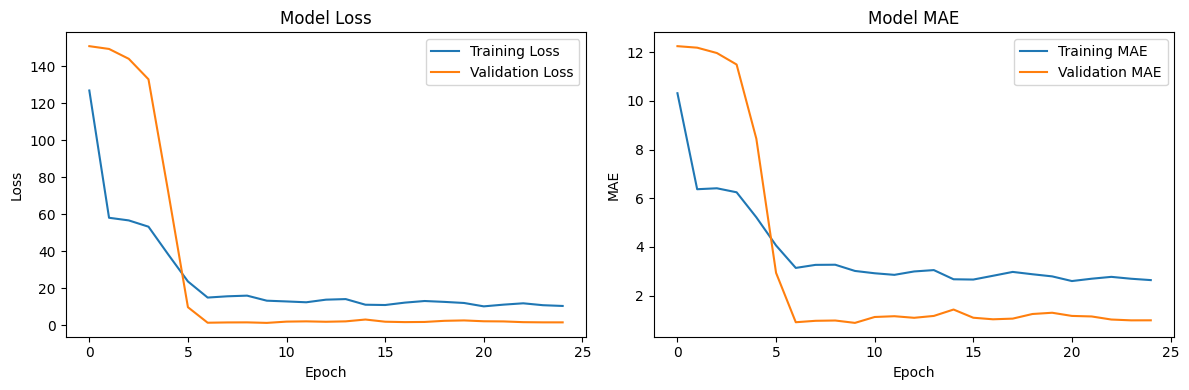

In [45]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()